In [116]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [118]:
os.chdir('../data40+')

In [6]:
os.chdir('drive/MyDrive/paperBuild/Compressor/data20')

In [119]:
!ls

data_0_1_.dat  data_2_0_.dat  data_4_0_.dat  data_6_0_.dat
data_1_0_.dat  data_3_1_.dat  data_5_1_.dat  data_7_1_.dat


In [120]:
!pwd

/content/drive/My Drive/paperBuild/Compressor/data40+


In [126]:
channels=[[4,5,6,7,8],[14,13,12,11,15],[18,19,20,21,22],[24,25,26,0,1]]
pressurecoeff=[[ 1580.1, 1595, 1457.4, 1450.1, 1414.1],[1204.9, 1048.4, 1185.7, 1191.5, 1201.4],[1194.7, 1201.2, 1194.5, 1851.9, 1773.9],[1198, 1203.4, 1199.7, 1299.9, 2077.2]]
hall=[3]
threshold=2.5 # 0~5

In [127]:
# data per revolution: 50000 samples/sec / (2400/60) =  1250
perRev=1250
# 2400 rpm 50KHz Blade Passage 60: 20 samples per passage per revolution
rev=7 # 10 revolution data considered between last 20 rev. to last 10 rev.
datapts=64 # 4 chords, before and after hall flags give 8 datapoints for each file.
# 8 files (4 no stall and 4 stall) generating 64 time series data. Each chord has
# specific pressure coefficient.
samples=20
chord_probes=5
batch=np.arange(0,datapts,2*len(channels))
dp=np.zeros([datapts,rev, samples, chord_probes]) # Trim 1st and last rev.

In [128]:
def hall_reform(hall_logic, threshold):
  data=hall_logic.values
  for i in range(len(data)):
    data[i] = 0 if data[i]>threshold else 1

  return data

def indices_work(hall_flag):
  temp=np.array([])
  for i in range(len(hall_flag)):
    if hall_flag[i]==1:
      temp=np.append(temp, i+1)

  return temp

In [129]:
for item in os.listdir():
  print(int(item.split('_')[2]))

0
1
0
1
1
0
0
1


In [130]:
p=0
target=np.array([])
for item in os.listdir():
  raw=pd.read_fwf(item, header=None)
  raw=raw.iloc[-60*perRev: -50*perRev,:]
  hall_logic=raw.iloc[:,hall]
  hall_logic=hall_reform(hall_logic, threshold)
  hall_flag=hall_logic[1:]-hall_logic[:-1] # Transition from high to low or low to high
  indices=indices_work(hall_flag)
  indices=indices.astype(int)

  for chord in np.arange(0,len(channels)):
    #for p in batch:
    #chord=0
    dataR=np.zeros([rev, samples, len(channels[chord][:])]) # Revolution, time series, sensors
    dataL=np.zeros([rev, samples, len(channels[chord][:])])
    n=0 # Revolution count
    coefficients=pressurecoeff[chord][:]
    for m in indices[1:rev+1]: #Revolution/Hall trigger for one file
      dataR[n]=raw.iloc[m:m+samples, channels[chord][:]].values # any coefficient multiplication should be done here
      dataR[n]=np.multiply(dataR[n], coefficients)
      #dataR[n]=preprocessing.normalize(dataR[n])
      dataL[n]=raw.iloc[m-samples:m, channels[chord][:]].values # any coefficient multiplication should be done here
      dataL[n]=np.multiply(dataL[n], coefficients)
      #dataL[n]=preprocessing.normalize(dataL[n])
      n=n+1

    dp[p]=dataR
    dp[p+1]=dataL
    target=np.append(target,int(item.split('_')[2]))
    target=np.append(target,int(item.split('_')[2]))
    p=p+2

    #break



In [131]:
dp.shape

(64, 7, 20, 5)

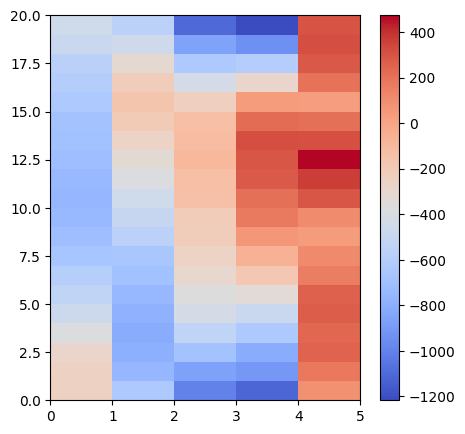

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
pcm = ax.pcolormesh(dp[0][0], cmap='coolwarm')
#pcm.set_clim(min(dp[0][0].reshape(-1)),max(dp[0][0].reshape(-1)))
fig.colorbar(pcm, ax=ax)
#ax.axis('off')
plt.show()

In [ ]:
data_=dp[0]
data_[data_==0]=0.0000001

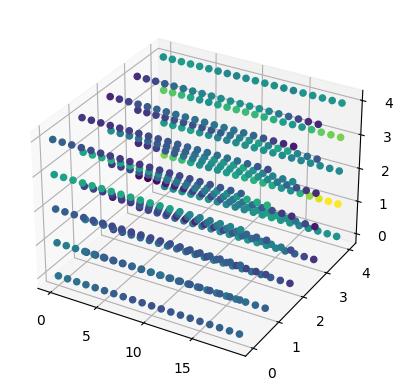

In [ ]:
layers=5

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, x, y = data_[0:layers].nonzero()
ax.scatter(x, y, z, c=data_[0:layers].reshape(-1), alpha=1)
plt.show()

In [ ]:
dp_=np.transpose(dp, (0,1,3,2))

In [ ]:
abs(np.corrcoef(dp_[0][0]))

array([[1.        , 0.61767611, 0.84718344, 0.89301331, 0.09248657],
       [0.61767611, 1.        , 0.41148144, 0.51721751, 0.11952132],
       [0.84718344, 0.41148144, 1.        , 0.98164924, 0.04088181],
       [0.89301331, 0.51721751, 0.98164924, 1.        , 0.04132523],
       [0.09248657, 0.11952132, 0.04088181, 0.04132523, 1.        ]])

In [ ]:
np.std(dp_[0][0], axis=-1)

array([161.64376375, 210.46106053, 310.27070802, 496.13520848,
       109.54559747])

In [ ]:
# Taking data with (sensors, time)
def adjacency(data, point, rev):
  adjacenc=abs(np.corrcoef(data[point][rev]))
  attributes=np.std(data[point][rev], axis=-1)

  return adjacenc, attributes


In [132]:
target

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [133]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [162]:
xtrain, xtest, ytrain, ytest = train_test_split(dp,target, test_size=0.25, random_state=1)

In [163]:
xtrain.shape

(48, 7, 20, 5)

In [164]:
ytrain.shape

(48,)

In [165]:
ytest

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.])

In [166]:
scaler=preprocessing.MinMaxScaler(feature_range=(0,1))
transformed=scaler.fit_transform(xtrain.reshape(xtrain.shape[0],-1))
xtrain=transformed.reshape(xtrain.shape)

transformed=scaler.transform(xtest.reshape(xtest.shape[0],-1))
xtest=transformed.reshape(xtest.shape)

In [167]:
np.max(xtrain[0][0])

1.0000000000000002

In [169]:
np.save('xtrain.npy',xtrain)

In [170]:
np.save('xtest.npy', xtest)
np.save('ytest.npy', ytest)
np.save('ytrain.npy', ytrain)

In [171]:
!ls

data_0_1_.dat  data_3_1_.dat  data_6_0_.dat  xtrain.npy
data_1_0_.dat  data_4_0_.dat  data_7_1_.dat  ytest.npy
data_2_0_.dat  data_5_1_.dat  xtest.npy      ytrain.npy
